**Stylising Images**

In the below notebook we will explore how we can transfer the style of an image to a new image. We will be referring to the paper: https://arxiv.org/abs/1508.06576

Context:

We have a Content image which we want to stylise according to the style image provided. We use VGG19 architecture to perform this task.

Selection of Model:

VGG19 is one of the best classifier models based on CNN architecture. Although we will not be performing classification in this code, the main idea to use this is to extract the feature maps from the model.

The architecture has 5 blocks which consists of multiple CNN layers. Each layer after the training will contain the information about different features of the image like edges, textures etc.. We will leverage this to form the new image.


We will first start by training a VGG19 with our own dataset.

Let's import the libraries

In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [13]:

dataset_dir = 'data'

# Specify the dimensions of your images
input_shape = (224, 224, 3) 

# Specify the number of classes in your dataset
num_classes = len(os.listdir(dataset_dir))

# Data preparation and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Specify 'training' for the training set
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Specify 'validation' for the validation set
)

Found 2550 images belonging to 2 classes.
Found 282 images belonging to 2 classes.


In [14]:

base_model = VGG19(weights=None, include_top=False, input_shape=(224, 224, 3))

# Add new classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='sigmoid')(x)  # Change num_classes to the number of classes in your dataset

# Create a new model
model = Model(base_model.input, x)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:

epochs = 50
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=epochs
)


Epoch 1/50
79/79 [==============================] - 76s 874ms/step - loss: 0.6496 - accuracy: 0.7228 - val_loss: 0.5826 - val_accuracy: 0.7422
Epoch 2/50
79/79 [==============================] - 58s 735ms/step - loss: 0.5819 - accuracy: 0.7339 - val_loss: 0.5925 - val_accuracy: 0.7227
Epoch 3/50
79/79 [==============================] - 64s 816ms/step - loss: 0.5852 - accuracy: 0.7327 - val_loss: 0.5867 - val_accuracy: 0.7266
Epoch 4/50
79/79 [==============================] - 61s 769ms/step - loss: 0.5832 - accuracy: 0.7327 - val_loss: 0.5828 - val_accuracy: 0.7305
Epoch 5/50
79/79 [==============================] - 64s 815ms/step - loss: 0.5824 - accuracy: 0.7335 - val_loss: 0.5905 - val_accuracy: 0.7227
Epoch 6/50
79/79 [==============================] - 60s 758ms/step - loss: 0.5808 - accuracy: 0.7347 - val_loss: 0.5762 - val_accuracy: 0.7383
Epoch 7/50
79/79 [==============================] - 58s 733ms/step - loss: 0.5817 - accuracy: 0.7323 - val_loss: 0.5789 - val_accuracy: 0.7344

We sucessfully trained the VGG19 model on our custom dataset. The dataset was chosen after "multiple Failures" of different models made on different datasets which is discussed in the last section. This was the 7th model that I trained and found it to be working the best.

The below code snippet is to detect if there are any faulty files in the dataset, it will detect them and remove them if any.

In [10]:
# from PIL import Image
# import os

# def is_image_file(filepath):
#     try:
#         # Try to open the image file
#         Image.open(filepath).verify()
#         return True
#     except Exception as e:
#         # Print the exception (you can customize this part based on your needs)
#         print(f"Error opening {filepath}: {e}")
#         return False

# def delete_unopenable_files(folder_path):
#     # List all files in the folder
#     files = os.listdir(folder_path)

#     # Iterate through each file
#     for file in files:
#         file_path = os.path.join(folder_path, file)

#         # Check if the file is an image and can be opened
#         if not is_image_file(file_path):
#             # If not, delete the file
#             os.remove(file_path)
#             print(f"Deleted {file_path}")

# # Specify the path to your folder
# folder_path = 'drive/MyDrive/data/iconography'

# # Call the function to delete unopenable files
# delete_unopenable_files(folder_path)


Error opening drive/MyDrive/data/iconography/331.jpg: cannot identify image file 'drive/MyDrive/data/iconography/331.jpg'
Deleted drive/MyDrive/data/iconography/331.jpg
Error opening drive/MyDrive/data/iconography/69.jpg: cannot identify image file 'drive/MyDrive/data/iconography/69.jpg'
Deleted drive/MyDrive/data/iconography/69.jpg


We will save the model for future uses

In [ ]:
model.save('2class_new.h5')

Now we start building the stylised image, firstly we import all the libraries

In [2]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
from tensorflow.keras.models import load_model

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

We define some functions to make it easy for us to visualise and process the image related stuff

In [4]:
#converts the tensorflow output to image
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

#extract the image from a given path
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

#Display the image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)


Let us load our model now, and try to see the different layers present in it. As the model is based on VGG19 architecture, we will get to see the different layers in it

In [5]:
vgg = load_model('2class_new.h5')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten_1
dense_2
dense_3


The way this works is, we need to extract the style of the image by using the gram matrix of the 'main' feature maps in the different blocks present in our architecture, so we select the first CNN layer of each block to build the gram matrix. To get the style we are using the 2nd CNN layer of the 5th block. So in the below code we just define them.

In [6]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

We make a function to define our model

In [7]:
def vgg_layers(layer_names):

  vgg = load_model('2class_new.h5')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

below are the paths to the Content image and the Style image that we will be using

In [8]:
content_path = '136.jpg'
style_path = 'Untitled.jpg'

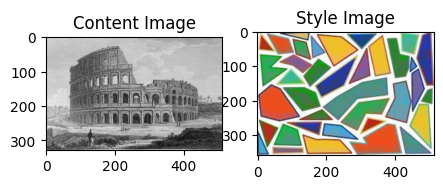

In [9]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [10]:
style_extractor = vgg_layers(style_layers)
content_image = tf.image.resize(content_image, (224, 224))
style_image = tf.image.resize(style_image, (224, 224))
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 224, 224, 64)
  min:  0.0
  max:  172.29892
  mean:  15.028507

block2_conv1
  shape:  (1, 112, 112, 128)
  min:  0.0
  max:  46.16883
  mean:  1.3280224

block3_conv1
  shape:  (1, 56, 56, 256)
  min:  0.0
  max:  13.605078
  mean:  0.22553468

block4_conv1
  shape:  (1, 28, 28, 512)
  min:  0.0
  max:  1.6821499
  mean:  0.04680252

block5_conv1
  shape:  (1, 14, 14, 512)
  min:  0.0
  max:  2.2877226
  mean:  0.13307516



Now we define a function that will calculate the gram matrix for the style layers that we defined earlier

In [11]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

The `StyleContentModel` is a TensorFlow Keras model designed for neural style transfer. It utilizes the VGG19 architecture to extract features from specified style and content layers. During initialization, the style and content layers are set, and the VGG19 model is created and marked as non-trainable. The `call` method processes input images, scales and preprocesses them, and extracts features at the specified layers. Style outputs are converted to Gram matrices, and the results are organized into dictionaries for content and style. The final output is a dictionary with keys 'content' and 'style', each containing relevant information.

In [12]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [13]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.021968698
    max:  1191.5695
    mean:  42.886456

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  130.98499
    mean:  0.37364882

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  10.710735
    mean:  0.01028039

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  0.017637568
    mean:  5.7926885e-05

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  0.035344668
    mean:  0.00026780812

Contents:
   block5_conv2
    shape:  (1, 14, 14, 512)
    min:  0.0
    max:  0.78866994
    mean:  0.010851096


Now from here we start the gradient descent. We basically take the content image and run a gradient descent on it based on a 'Content-Style' loss that we define as a weightem sum of content loss and style loss. We get content loss simply by an MSE between the original content image and target image where as for style loss we incorporate the gram matrix on style layers and then consider the MSE.

In [14]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [15]:
image = tf.Variable(content_image)

In [16]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

As the loss is a weighted sum, we can adjust the amount of style or content that we need in the target image by adjusting the weights over here.

In [18]:
style_weight=1e3
content_weight=1e4

In [19]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [20]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

After we define all the functions for gradient descent, we just run the gradient desecent for a few steps first and see the result

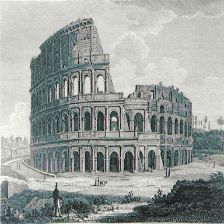

In [21]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Now we run this for 10 epochs and we get the final image

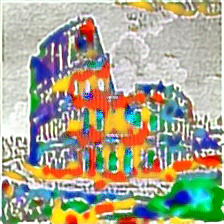

Train step: 1000
Total time: 5815.3


In [23]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

We can see the different layers in action that are being extracted by the CNN in the below code. 

In [24]:
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [25]:
from tensorflow.keras.preprocessing.image import array_to_img
#vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg = load_model('2class_new.h5')
def tensor_to_image(tensor, channel_index=0):
    # Check if the tensor has a batch dimension and squeeze it
    if len(tensor.shape) == 4:
        assert tensor.shape[0] == 1  # Ensure it's a single example in the batch
        tensor = np.squeeze(tensor, axis=0)

    assert len(tensor.shape) == 3  # Ensure it's a 3D tensor
    tensor_channel = tensor[:, :, channel_index]  # Select a specific channel
    tensor_rgb = np.stack((tensor_channel,) * 3, axis=-1)  # Stack to create a 3-channel image
    tensor_rgb = tensor_rgb.astype(np.uint8)  # Convert to NumPy array
    return array_to_img(tensor_rgb)


1/1 [==============================] - 29s 29s/step


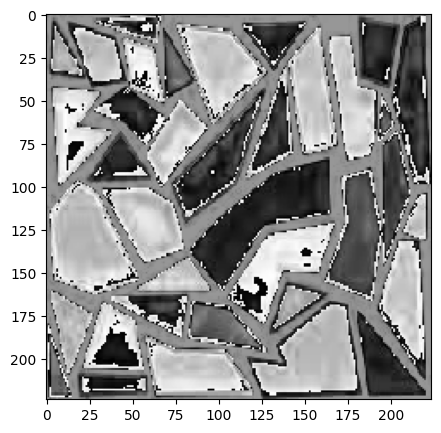

input_2
1/1 [==============================] - 1s 1s/step


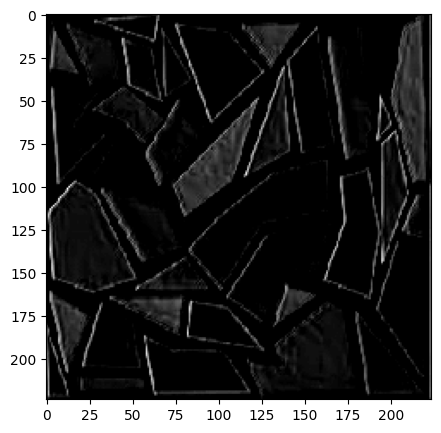

block1_conv1
1/1 [==============================] - 1s 1s/step


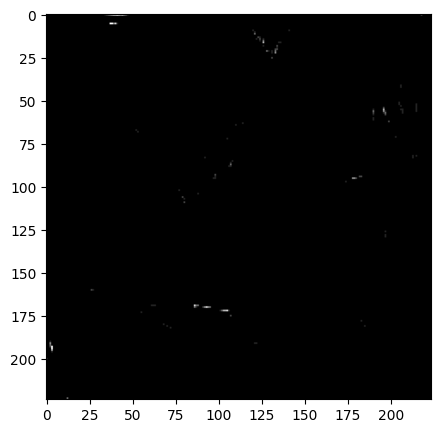

block1_conv2
1/1 [==============================] - 0s 245ms/step


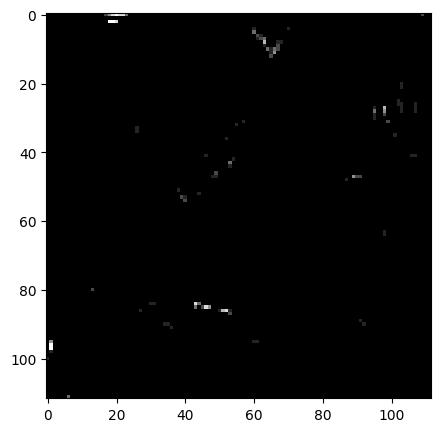

block1_pool
1/1 [==============================] - 1s 615ms/step


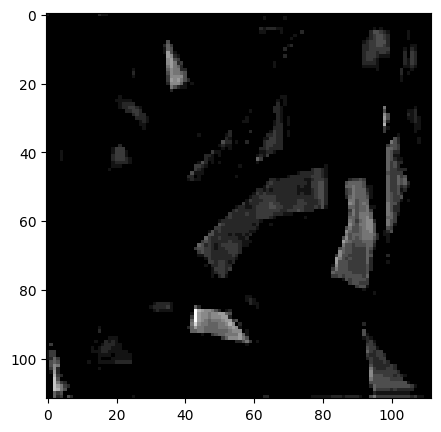

block2_conv1
1/1 [==============================] - 0s 231ms/step


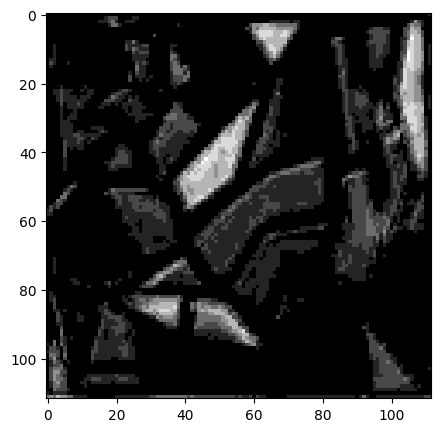

block2_conv2
1/1 [==============================] - 0s 355ms/step


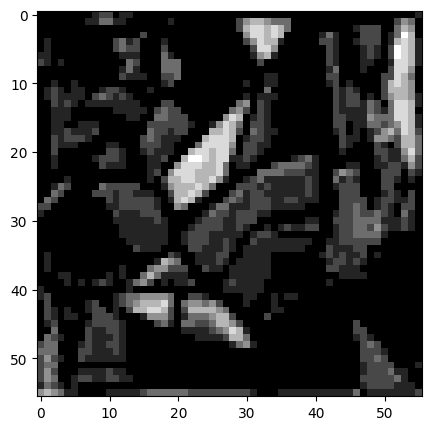

block2_pool
1/1 [==============================] - 0s 227ms/step


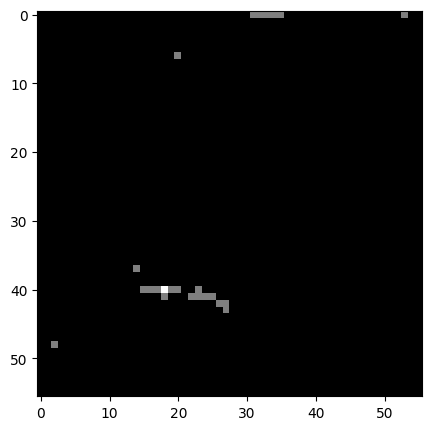

block3_conv1
1/1 [==============================] - 0s 279ms/step


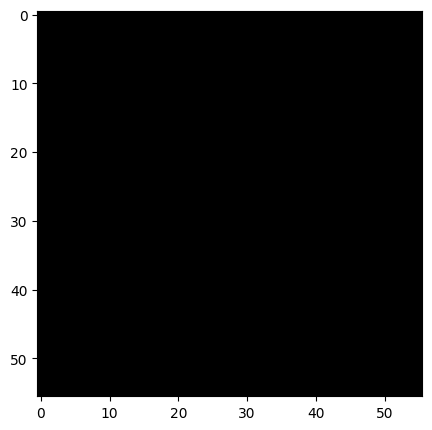

block3_conv2
1/1 [==============================] - 0s 359ms/step


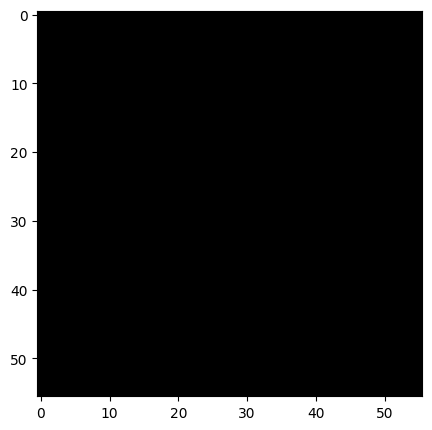

block3_conv3
1/1 [==============================] - 0s 423ms/step


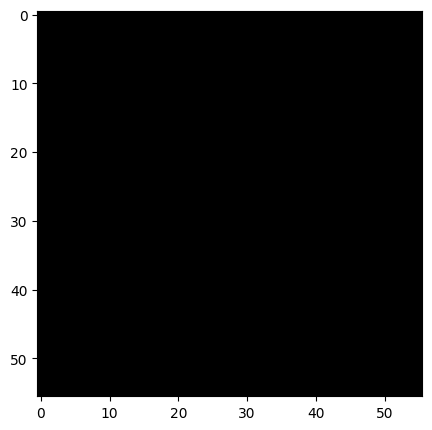

block3_conv4
1/1 [==============================] - 0s 434ms/step


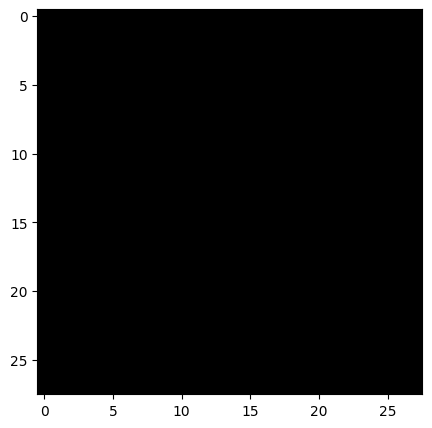

block3_pool
1/1 [==============================] - 0s 328ms/step


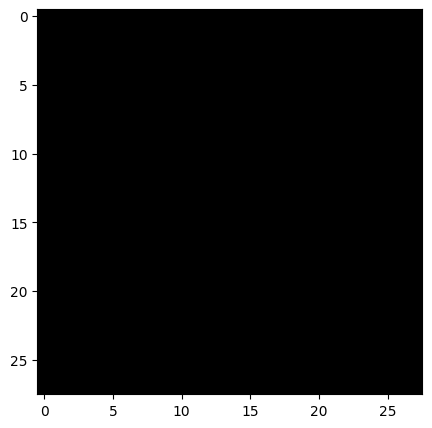

block4_conv1
1/1 [==============================] - 0s 385ms/step


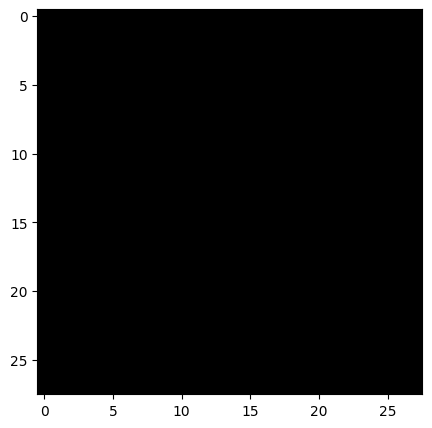

block4_conv2
1/1 [==============================] - 0s 367ms/step


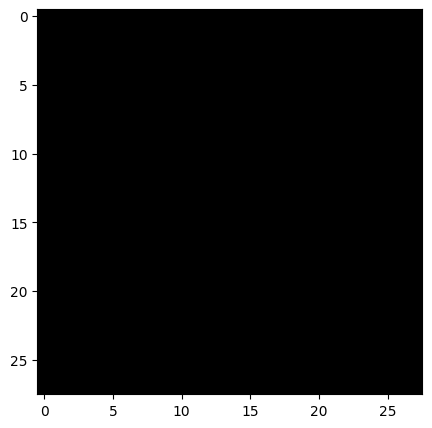

block4_conv3
1/1 [==============================] - 0s 469ms/step


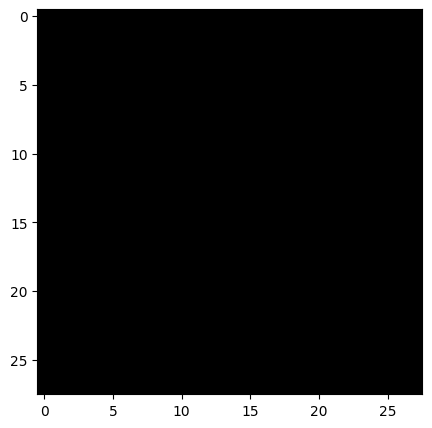

block4_conv4
1/1 [==============================] - 0s 489ms/step


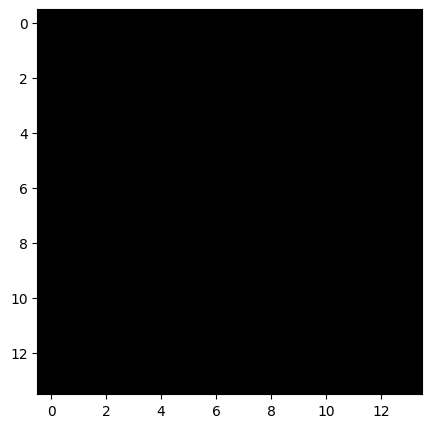

block4_pool
1/1 [==============================] - 0s 446ms/step


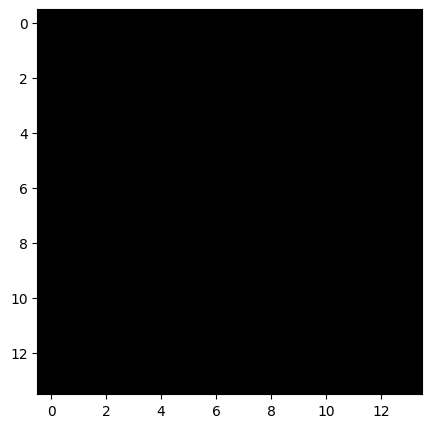

block5_conv1
1/1 [==============================] - 1s 547ms/step


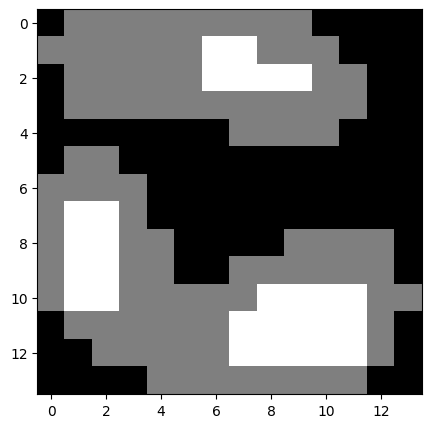

block5_conv2
1/1 [==============================] - 1s 538ms/step


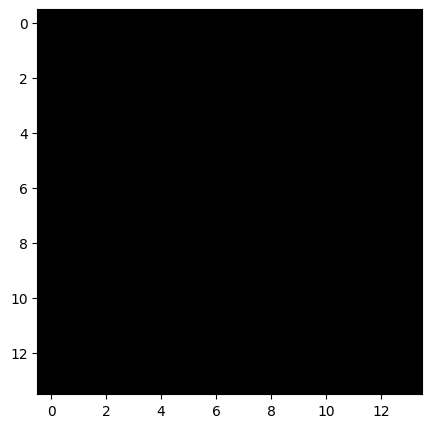

block5_conv3
1/1 [==============================] - 1s 915ms/step


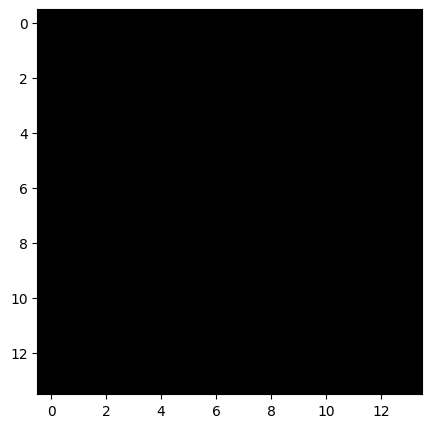

block5_conv4
1/1 [==============================] - 1s 539ms/step


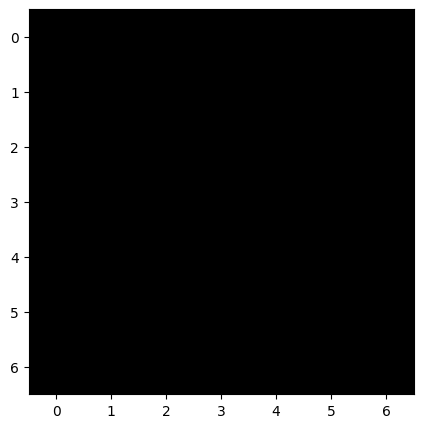

block5_pool


In [26]:
for l in vgg.layers:
  layer = l.name
  m = Model(inputs = vgg.input, outputs = vgg.get_layer(layer).output)

  #img_path = 'images/resized/Albrecht_Du╠êrer/Albrecht_Du╠êrer_2.jpg'
  img_path = 'Untitled.jpg'
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input(img_array)
  plt.imshow(tensor_to_image(m.predict(img_array), channel_index= 0))
  plt.show()
  print(layer)
  if layer == 'block5_pool':
    break

As we can see, the model could transfer the style of the image by the means of coloring scheme. It could not very well replicate the structure and shape of the styel image, but this limitation is due to the limited training resources we had with us. If the same thing is trained on Pre trained VGG19 with imagenet dataset we could have gotten a much better result.

**Using Imagenet Pre Trained VGG19**

If we change the vgg function above as the code given below we can get much better results.

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

If we use the above function instead of our custom trained function, we will get much better results like the following shown:

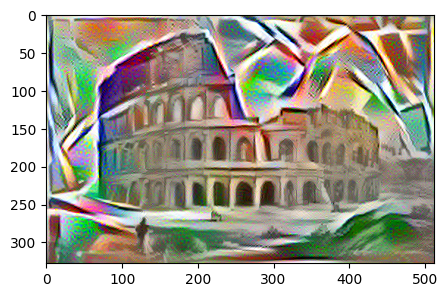

In [27]:
ima = load_img('imagenet.png')
imshow(ima)

This difference is mainly because the CNN is able to capture the features in a better way as it is extensively trained. This can be clearly seen in the feature maps that is shown below

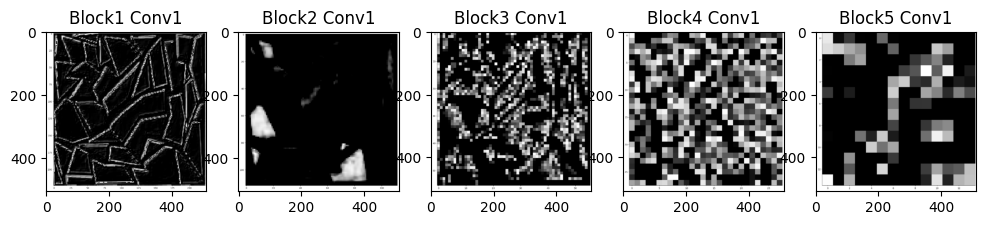

In [33]:
mpl.rcParams['figure.figsize'] = (12, 12)
plt.subplot(1,5,1)
imshow(load_img('b1c1.png'),'Block1 Conv1')
plt.subplot(1,5,2)
imshow(load_img('b2c1.png'),'Block2 Conv1')
plt.subplot(1,5,3)
imshow(load_img('b3c1.png'),'Block3 Conv1')
plt.subplot(1,5,4)
imshow(load_img('b4c1.png'),'Block4 Conv1')
plt.subplot(1,5,5)
imshow(load_img('b5c1.png'),'Block5 Conv1')


As we can see above, the details captured by imagenet trained VGG19 are very intricate, so we are able to get better quality images

**Pitfalls and Improvements**


So the current model that i have developed used the dataset from https://www.kaggle.com/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving?select=dataset. I have trained it only on two types of arts, namely engravings and iconography. The reason that i chose these two forms of art is that they are easily distinguishable and makes the training and feature learning easier.

Initially I trained on 50 Artists dataset, but it was an utter failure. After a very time consuming training on 10,000+ images for a lot of hours all i could get was an accuracy of 19% for the classification on 50 classes. Clearly it is not possible for the model to learn the art of 50 artists with a mere dataset of 100-800 images per artist. The feature learning and distnguishing by the mode lwas very poor, thus I could not extract a lot of features using it. 

I chose binary classification so that I could be able to extract atleast some feature of a particular kind of style efficiently, i tried it on many datasets to get the perfect extraction. Initially some datasets were chosen of different artists, but the uniformity in the art is not very much observed, to extract those intricate features we would require a bigger dataset for a particular artist. Thus by training on those models I could get some stylised images but they were quite noisy and not upto the mark.

Finally i chose to train a binary classification model based on style of paintings instead of artist, so that I could get a bigger dataset, and evidently I got better feature ectraction using the engravings and iconography datasets.


Below are some more images made by my Model, I have also shown VGG19 pre trained models' images for reference. 

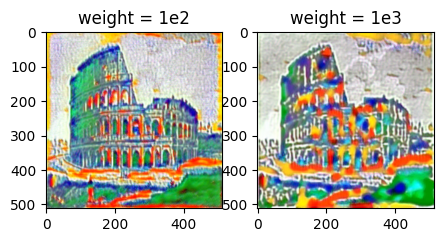

In [36]:
w1 = load_img('w1.png')
w2 = load_img('w2.png')
mpl.rcParams['figure.figsize'] = (5, 5)
plt.subplot(1,2,1)
imshow(w1,'weight = 1e2')
plt.subplot(1,2,2)
imshow(w2,'weight = 1e3')

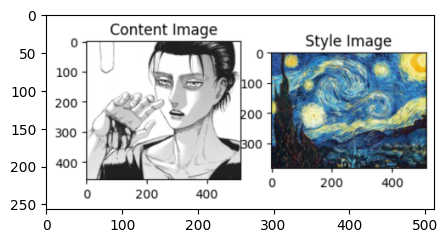

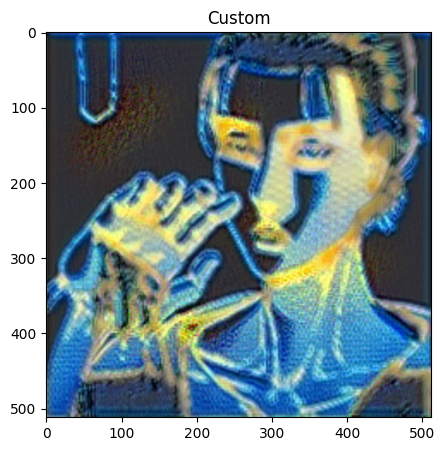

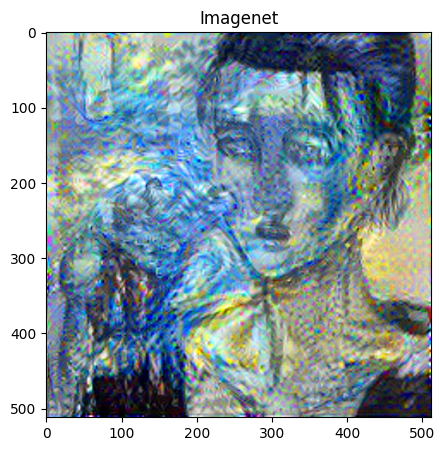

In [46]:
exa = load_img('example1.png')
imshow(exa)
plt.show()

e1 = load_img('result1.png')
e2 = load_img("result1 inet.png")


imshow(e1,'Custom')
plt.show()
imshow(e2,'Imagenet')

plt.show()

In conclusion, our model is able to replicate the color scheme of the style image accurately, it only lacks in extracting the texture features, which can be very well achieved with a good dataset.